In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                      
from iminuit import Minuit
from iminuit.cost import LeastSquares
from itertools import accumulate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

In [2]:
t1 = np.load('times_HLA.npy')
t2_initial = np.load('times_DAZ.npy')
times3_initial = np.load('times_LWN.npy')
times4_initial = np.load('times_PVX.npy')

t2 = [sum(t2_initial[i:i+2]) for i in range(0, len(t2_initial) ,2 )]
t3 = [sum(times3_initial[i:i+3]) for i in range(0, len(times3_initial), 3)]
t4 = [sum(times4_initial[i:i+3]) for i in range(0, len(times4_initial), 3)]
del t2[-1]
del t3[-1]
del t4[-1]

t1a = np.cumsum(t1)
t2a = np.cumsum(t2)
t3a = np.cumsum(t3)
t4a = np.cumsum(t4)

In [3]:
save_plots = False
Minuit.print_level = 0

#Uncertaintees
a = 9.3
b = 0
sigmay = 0.2

array_a = np.zeros(1)
array_b = np.zeros(1)
array_Chi2 = np.zeros(1)
array_Prob = np.zeros(1)

for iexp in range(1) : 
    x = np.arange(len(t2a))+1
    y = np.array(t2a) 
    sy = sigmay*np.ones_like(x)

    def fit_func(x, a, b): 
        return a*x + b
    
    chi2 = LeastSquares(x,y,sy,fit_func)
    
    def chi2_func(a,b):
        return np.sum(((y - fit_func(x,a,b)) / sy)**2)
    
    mfit = Minuit(chi2_func,a=a,b=b)

    mfit.migrad();
    
    a_fit = mfit.values['a']
    b_fit = mfit.values['b']
    sigma_a_fit = mfit.errors['a']
    sigma_b_fit = mfit.errors['b']
    
    Nvar = 2                     
    Ndof_fit = len(t2a) - Nvar
    
    Chi2_fit = mfit.fval                            
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    
    
    array_a[iexp] = a_fit
    array_b[iexp] = b_fit
    array_Chi2[iexp] = Chi2_fit
    array_Prob[iexp] = Prob_fit
    
    
    print(f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  p={Prob_fit:6.4f}")
    


  Fit: a= 9.397+-0.003  b=-0.033+-0.066  p=1.0000


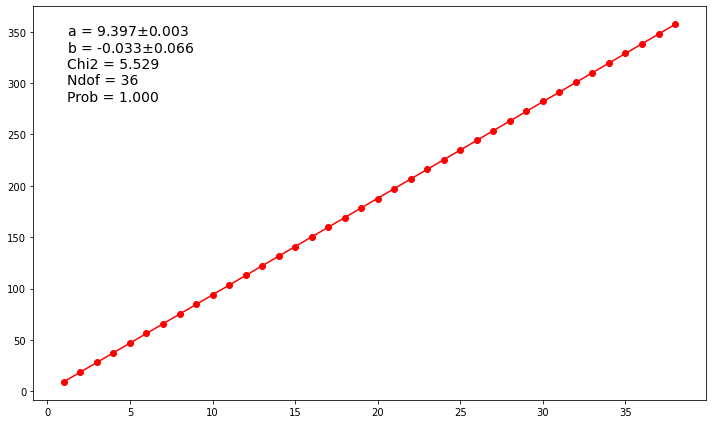

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_func(x, *mfit.values[:]), '-r')      # Note how we can "smartly" input the fit values!
plt.close()

fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToLine.pdf")
fig

In [32]:
column1_list = []
column2_list = []

with open('måling_ude_på_et_skråplan\data_side_1_ball_2_tias.csv', 'r') as file:
    for _ in range(15):
        file.readline()
    for line in file:
        columns = line.strip().split(',')
        if len(columns) == 2: 
            column1_list.append(columns[0])
            column2_list.append(columns[1])

In [33]:
indexes_column2 = [i for i, value in enumerate(column2_list) if float(value) > 3]
float_column2 = [float(num) for num in column2_list]

def find_indexes(a,b):
    max_value = max(float_column2[a:b + 1])
    max_index_in_slice = float_column2[a:b + 1].index(max_value)
    max_index = a + max_index_in_slice
    t_1 = column1_list[max_index]
    return f"max voltage: {max_value}", f"time: {t_1}"

    
v1, t1 = find_indexes(5148, 5277) 
print(v1,t1)
v2, t2 = find_indexes(6503, 6574) 
print(v2,t2)
v3, t3 = find_indexes(7417, 7469) 
print(v3,t3)
v4, t4 = find_indexes(8176, 8225) 
print(v4,t4)
v5, t5 = find_indexes(8779, 8820) 
print(v5,t5)

t = [0.5426,0.8080000000000001,0.9894000000000001,1.1396, 1.2596]



max voltage: 4.947268245405789 time: 0.5426
max voltage: 4.947608883919865 time: 0.8080000000000001
max voltage: 4.947608883919865 time: 0.9894000000000001
max voltage: 4.94794952243394 time: 1.1396
max voltage: 4.948290160948016 time: 1.2596


In [30]:
sensor_afstand_1 = np.array([18.6,36.4,54.5,73.6,91.2]) / 100
sensor_afstand_2 = np.array([18.7,36.3,54.6,73.5,91.2]) / 100
sensor_afstand_3 = np.array([18.7,36.4,54.6,73.55,91.65]) / 100
sensor_afstand_4 = np.array([18.4,36.4,54.5,73.5,91.2]) / 100
samlet_afstand = (sensor_afstand_1 + sensor_afstand_2 + sensor_afstand_3 + sensor_afstand_4) / 4 

d_r_inder = 0.006 
bold_1 = 0.01

vinkel_v = (76.1 + 76.5 + 76.1 + 76.2) / 4
vinkel_h = (76 + 76.3 + 75.95 + 75.9) / 4 
vinkel_v1 = (76.4 + 76.5 + 76.2 + 76.3) / 4
vinkel_h1 = (75.9 + 76.5 + 76 + 76) / 4
samlet_vinkel = (vinkel_v + vinkel_h + vinkel_v1 + vinkel_h1) / 4


In [21]:
c = 5
d = 0
sigmay = 0.2

array_c = np.zeros(1)
array_d = np.zeros(1)
array_Chi2 = np.zeros(1)
array_Prob = np.zeros(1)

for iexp in range(1) : 
    #x = np.arange(len(t))+1
    x = np.array(t)
    #y = np.array(t)
    y = np.array(samlet_afstand)
    sy = sigmay*np.ones_like(x)

    def fit_func(x, c, d): 
        return (1/2)*c*x**2 + d*x
    
    chi2 = LeastSquares(x,y,sy,fit_func)
    
    def chi2_func(c,d):
        return np.sum(((y - fit_func(x,c,d)) / sy)**2)
    
    mfit = Minuit(chi2_func,c=c,d=d)

    mfit.migrad();
    
    c_fit = mfit.values['c']
    d_fit = mfit.values['d']
    sigma_c_fit = mfit.errors['c']
    sigma_d_fit = mfit.errors['d']
    
    Nvar = 2                   
    Ndof_fit = len(t) - Nvar
    
    Chi2_fit = mfit.fval                            
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    
    
    array_c[iexp] = c_fit
    array_d[iexp] = d_fit
    array_Chi2[iexp] = Chi2_fit
    array_Prob[iexp] = Prob_fit
    
    
    print(f"  Fit: c={c_fit:6.3f}+-{sigma_c_fit:5.3f}  d={d_fit:5.3f}+-{sigma_d_fit:5.3f}  p={Prob_fit:6.4f}")
    


  Fit: c= 1.132+-0.903  d=0.003+-0.490  p=0.9994


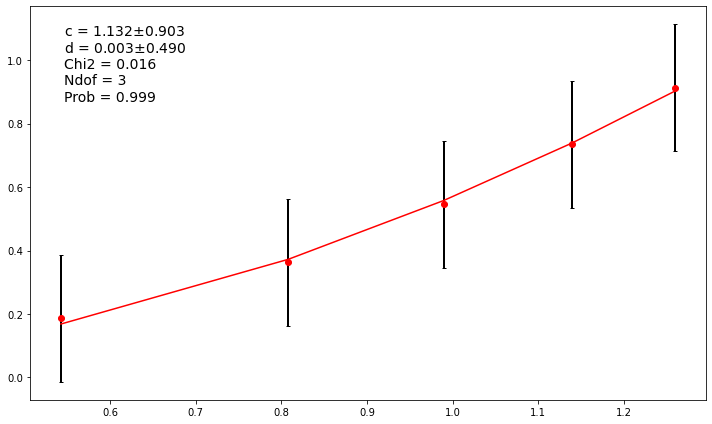

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_func(x, *mfit.values[:]), '-r')      
plt.close()

#ax.invert_xaxis()
#ax.invert_yaxis()

fit_info = [f'c = {c_fit:5.3f}' + r'$\pm$' +  f"{sigma_c_fit:5.3f}",
            f'd = {d_fit:5.3f}' + r'$\pm$' + f"{sigma_d_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToLine.pdf")
fig

In [23]:
a_1 = 1.132 
theta = np.deg2rad(180-samlet_vinkel-90)
g = (a_1 / np.sin(theta)) * (1+(2/5)*(bold_1**2) / (bold_1**2 - d_r_inder**2))
print(g)



7.69973872684724
